## Оценка качества векторов в Qdrant

Для оценки качества векторов в базе данных Qdrant используются следующие метрики и тесты:

### 1. **Косинусная близость (Cosine Similarity)**
   - Измеряет близость между двумя векторами в диапазоне от -1 до 1.
   - Чем ближе значение к 1, тем более схожи векторы.


### 2. **Евклидово расстояние (Euclidean Distance)**
   - Измеряет "расстояние" между двумя векторами в пространстве.
   - Чем меньше значение, тем ближе векторы.


### 3. **Проверка валидности векторов**
   - Проверяет, что векторы не содержат `NaN` или `inf`.
   - Подсчитывает количество валидных и невалидных векторов.

### 4. **Распределение векторов**
   - Визуализирует распределение значений первой координаты векторов.
   - Позволяет оценить, насколько равномерно распределены векторы в пространстве.

### 5. **Тесты на схожесть и несхожесть**
   - **Тест на схожесть**: Проверяет, что схожие объекты (например, документы на одну тему) имеют высокое косинусное сходство.
   - **Тест на несхожесть**: Проверяет, что несхожие объекты (например, документы на разные темы) имеют низкое косинусное сходство или большое евклидово расстояние.

In [24]:
# библиотеки
from qdrant_client import QdrantClient
from qdrant_client.http.models import ScrollRequest
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Подключение к Qdrant
client = QdrantClient(url="http://192.168.137.253:6333")
collection_name = "documents_collection"

# Инициализация модели SentenceTransformer
model_name = "deepvk/USER-bge-m3"
model = SentenceTransformer(model_name)

In [26]:
# Запрос
query = "О чем говорится в Таблица 6.3?"
query_vector = model.encode(query).tolist()

# Поиск в коллекции
search_results = client.search(
    collection_name='documents_collection',
    query_vector=query_vector,
    limit=7,
)

# Вывод результатов и метрик
for result in search_results:
    print(f"Score: {result.score}")
    print(f"Content: {result.payload['content']}")
    print(f"ID: {result.id}")

    # Получаем вектор из результата
    result_vector = np.array(result.vector, dtype=np.float32)

    # Если вектор содержит NaN, вычисляем его заново на основе текста контента
    if np.isnan(result_vector).any():
        result_vector = model.encode(result.payload['content']).tolist()
        result_vector = np.array(result_vector, dtype=np.float32)

    # Преобразование векторов в двумерные массивы
    query_vector_2d = np.array(query_vector).reshape(1, -1)
    result_vector_2d = result_vector.reshape(1, -1)

    # Косинусное сходство
    similarity = cosine_similarity(query_vector_2d, result_vector_2d)[0][0]
    print(f"Cosine Similarity: {similarity}")

    # Евклидово расстояние
    distance = euclidean(query_vector, result_vector)
    print(f"Euclidean Distance: {distance}")
    print("-" * 40)

Score: 0.7650932
Content: Продолжение таблицы 6.3
ID: ce20db24-f76a-4a21-a446-9b3d70e34c8a
Cosine Similarity: 0.7650931559840778
Euclidean Distance: 0.6854295594578045
----------------------------------------
Score: 0.5822097
Content: Таблица 6.3   Участок III  г.Лиски – г.Павловск, млн.м3
ID: 170594c6-439b-4b6b-b1b5-39b64da9e9da
Cosine Similarity: 0.5822095972129135
Euclidean Distance: 0.9141011130163286
----------------------------------------
Score: 0.55178523
Content: Продолжение таблицы 8.3
ID: 8c013ff2-8ec9-4e73-9aac-3159448e52a9
Cosine Similarity: 0.551785194792185
Euclidean Distance: 0.946799707922301
----------------------------------------
Score: 0.53755605
Content: плана мероприятий по строительству Кос и сетей канализации, намеченных в региональных программах «Чистая вода» [19 33] 6.2. Водоотведение Значения целевых показателей развития систем водоотведения в субъектах Рф на рассматриваемой территории по годам прогнозного периода приведены в таблице 7.2., цель 2. 6.3. Гидро

Step 1: Validity Check
Valid vectors: 100, Invalid vectors: 0

Step 2: Cosine Similarity Check
Один из векторов пустой. Проверьте данные.

Step 3: Vector Distribution Plot


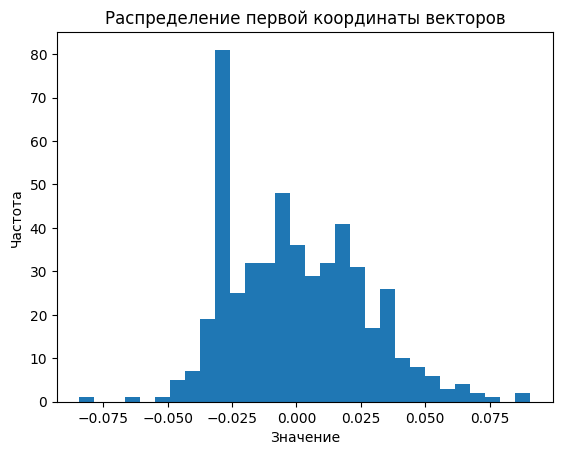


Step 4: Distance Check
Один из векторов содержит NaN. Проверьте данные.


In [27]:
# 1. Проверка валидности векторов
def check_vectors_validity(client, collection_name, sample_size=100):
    valid_count = 0
    invalid_count = 0

    # Используем ScrollRequest для скроллинга
    scroll_response = client.scroll(
        collection_name=collection_name,
        scroll_filter=None,
        limit=sample_size,
        with_payload=False,
        with_vectors=True
    )

    # scroll_response возвращает кортеж (points, offset)
    points, _ = scroll_response

    for point in points:
        vector = np.array(point.vector, dtype=np.float32)  # Преобразуем в массив NumPy
        if vector is None or np.isnan(vector).any() or np.isinf(vector).any():
            print(f"Invalid vector ID: {point.id}")
            invalid_count += 1
        else:
            valid_count += 1

    print(f"Valid vectors: {valid_count}, Invalid vectors: {invalid_count}")

# 2. Косинусное сходство между схожими объектами
def check_similarity(client, collection_name, model, text_a, text_b):
    # Генерация векторов для текстов
    vector_a = model.encode(text_a)
    vector_b = model.encode(text_b)

    # Поиск ближайших векторов в базе
    response_a = client.search(
        collection_name=collection_name,
        query_vector=vector_a,
        limit=1
    )
    response_b = client.search(
        collection_name=collection_name,
        query_vector=vector_b,
        limit=1
    )

    # Извлечение найденных векторов
    db_vector_a = response_a[0].vector
    db_vector_b = response_b[0].vector

    # Проверка на None
    if db_vector_a is None or db_vector_b is None:
        print("Один из векторов пустой. Проверьте данные.")
        return

    # Преобразование векторов в массивы NumPy
    db_vector_a = np.array(db_vector_a, dtype=np.float32)  # Явное указание типа
    db_vector_b = np.array(db_vector_b, dtype=np.float32)  # Явное указание типа

    # Проверка на наличие NaN
    if np.isnan(db_vector_a).any() or np.isnan(db_vector_b).any():
        print("Один из векторов содержит NaN. Проверьте данные.")
        return

    # Преобразование векторов в двумерные массивы
    db_vector_a = db_vector_a.reshape(1, -1)  # Преобразуем в 2D
    db_vector_b = db_vector_b.reshape(1, -1)  # Преобразуем в 2D

    # Косинусное сходство
    similarity = cosine_similarity(db_vector_a, db_vector_b)
    print(f"Cosine Similarity between objects: {similarity[0][0]}")

# 3. Распределение векторов
def plot_vector_distribution(client, collection_name, sample_size=500):
    vectors = []

    # Скроллинг базы для выборки векторов
    scroll_response = client.scroll(
        collection_name=collection_name,
        scroll_filter=None,
        limit=sample_size,
        with_payload=False,
        with_vectors=True
    )

    # scroll_response возвращает кортеж (points, offset)
    points, _ = scroll_response

    for point in points:
        vectors.append(point.vector)

    vectors = np.array(vectors, dtype=np.float32)  # Преобразуем в массив NumPy

    # Построение распределения первого измерения
    plt.hist(vectors[:, 0], bins=30)
    plt.title("Распределение первой координаты векторов")
    plt.xlabel("Значение")
    plt.ylabel("Частота")
    plt.show()

# 4. Расстояние между несхожими объектами
def check_distance(client, collection_name, model, text_a, text_b):
    # Генерация векторов для текстов
    vector_a = model.encode(text_a)
    vector_b = model.encode(text_b)

    # Поиск ближайших векторов в базе
    response_a = client.search(
        collection_name=collection_name,
        query_vector=vector_a,
        limit=1
    )
    response_b = client.search(
        collection_name=collection_name,
        query_vector=vector_b,
        limit=1
    )

    # Извлечение найденных векторов
    db_vector_a = np.array(response_a[0].vector, dtype=np.float32)  # Преобразуем в массив NumPy
    db_vector_b = np.array(response_b[0].vector, dtype=np.float32)  # Преобразуем в массив NumPy

    # Проверка на None
    if db_vector_a is None or db_vector_b is None:
        print("Один из векторов пустой. Проверьте данные.")
        return

    # Проверка на наличие NaN
    if np.isnan(db_vector_a).any() or np.isnan(db_vector_b).any():
        print("Один из векторов содержит NaN. Проверьте данные.")
        return

    # Евклидово расстояние (передаем одномерные массивы)
    distance = euclidean(db_vector_a, db_vector_b)
    print(f"Euclidean distance between objects: {distance}")

# Выполнение проверок
if __name__ == "__main__":
    print("Step 1: Validity Check")
    check_vectors_validity(client, collection_name)

    print("\nStep 2: Cosine Similarity Check")
    check_similarity(
        client,
        collection_name,
        model,
        "This is a sample document about AI.",
        "This is another document related to artificial intelligence."
    )

    print("\nStep 3: Vector Distribution Plot")
    plot_vector_distribution(client, collection_name)

    print("\nStep 4: Distance Check")
    check_distance(
        client,
        collection_name,
        model,
        "This is a document about space exploration.",
        "This is a completely unrelated topic about cooking."
    )